In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
from CGCNN_MT.module.module_utils import calculate_lsd, calculate_lse, calculate_lsv
from sklearn import metrics
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# log_dir = "./CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_142"
log_dir = "./CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43"
# log_dir = "./CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24"
log_dir = Path(log_dir)
fig_dir = Path("./CGCNN_MT/evaluation/figures")
latent_feas = {}
targets = {}
targets_map = {
    "SSD": {0: "unstable", 1: "stable"},
    "WS24_water": {0: "unstable", 1: "stable"},
    "WS24_water4": {0: "U", 1: "LK", 2: "HK", 3: "TS"},
    "WS24_acid": {0: "unstable", 1: "stable"},
    "WS24_base": {0: "unstable", 1: "stable"},
    "WS24_boiling": {0: "unstable", 1: "stable"},
}
predictions = {}
probs = {}
for task in ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]:
    for split in [
        'train', 
        'val', 
        'test',
        # "external_test"
        ]:
        latent_fea = np.load(log_dir / f"{split}_last_layer_fea_{task}.npz")
        latent_feas[f"{task}_{split}"] = latent_fea[list(latent_fea.keys())[0]]
        res_df = pd.read_csv(log_dir / f"{split}_results_{task}.csv")
        # if task == "TSD":
        #     targets[f"{task}_{split}"] = (res_df['GroundTruth'].values > 359).astype(int)
        # else:
        targets[f"{task}_{split}"] = res_df['GroundTruth'].values
        predictions[f"{task}_{split}"] = res_df['Predicted'].values
        if "Prob" in res_df.columns:
            probs[f"{task}_{split}"] = np.array([eval(p) if isinstance(p, str) else p for p in res_df['Prob'].values])

In [3]:
def plot_tsne_for_task_by_targets(task, latent_feas, targets, targets_map, ax, size=10, **kwargs):
    all_latent_feas = []
    all_targets = []
    all_splits = []
    x_label = kwargs.get('x_label', True)
    y_label = kwargs.get('y_label', True)
    cb_pad = kwargs.get('cb_pad', 0.05)
    tick_font_size = kwargs.get('tick_font_size', 12)
    label_font_size = kwargs.get('label_font_size', 12)

    # Concatenate all latent features and targets for the task
    for split in ['train', 'val', 'test']:
        key = f"{task}_{split}"
        if key in latent_feas:
            all_latent_feas.append(latent_feas[key])
            all_targets.append(targets[key])
            all_splits.extend([split] * len(latent_feas[key]))

    all_latent_feas = np.concatenate(all_latent_feas, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Perform TSNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(all_latent_feas)

    # Create a DataFrame for visualization
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['Label'] = all_targets
    tsne_df['Split'] = all_splits
    tsne_df['Size'] = [size] * len(tsne_df)

    # Determine if the task is classification or regression
    unique_targets = np.unique(all_targets)
    is_classification = len(unique_targets) < 20

    if is_classification:
        tsne_df['Label'] = tsne_df['Label'].apply(lambda x: targets_map[task][int(x)])
        sns.scatterplot(
            x="TSNE1", y="TSNE2",
            hue='Label',
            style='Label',
            sizes="Size",
            palette=sns.color_palette("hsv", len(unique_targets), desat=0.6),
            data=tsne_df,
            alpha=kwargs.get('alpha', 0.5),
            markers=True,
            ax=ax
        )
        if x_label:
            ax.set_xlabel('TSNE1', fontsize=label_font_size)
        if y_label:
            ax.set_ylabel('TSNE2', fontsize=label_font_size)
        ax.legend(loc='best', fontsize=tick_font_size)
        
    else:
        norm = Normalize(vmin=all_targets.min(), vmax=all_targets.max())
        cmap = plt.get_cmap('viridis')
        scatter = ax.scatter(
            tsne_df['TSNE1'], tsne_df['TSNE2'],
            c=all_targets, cmap=cmap, norm=norm,
            alpha=kwargs.get('alpha', 0.5)
        )
        if x_label:
            ax.set_xlabel('TSNE1', fontsize=label_font_size)
        if y_label:
            ax.set_ylabel('TSNE2', fontsize=label_font_size)
        cbar = plt.colorbar(scatter, orientation='horizontal', pad=cb_pad, ax=ax)
        cbar.set_label('T$_d$', fontsize=14)

    ax.set_title(f"Last-Layer Features ({task})", weight='bold', fontsize=label_font_size+1)
    ax.tick_params(axis='both', labelsize=tick_font_size)
    ax.xaxis.label.set_size(label_font_size)
    ax.yaxis.label.set_size(label_font_size)
    
    return ax

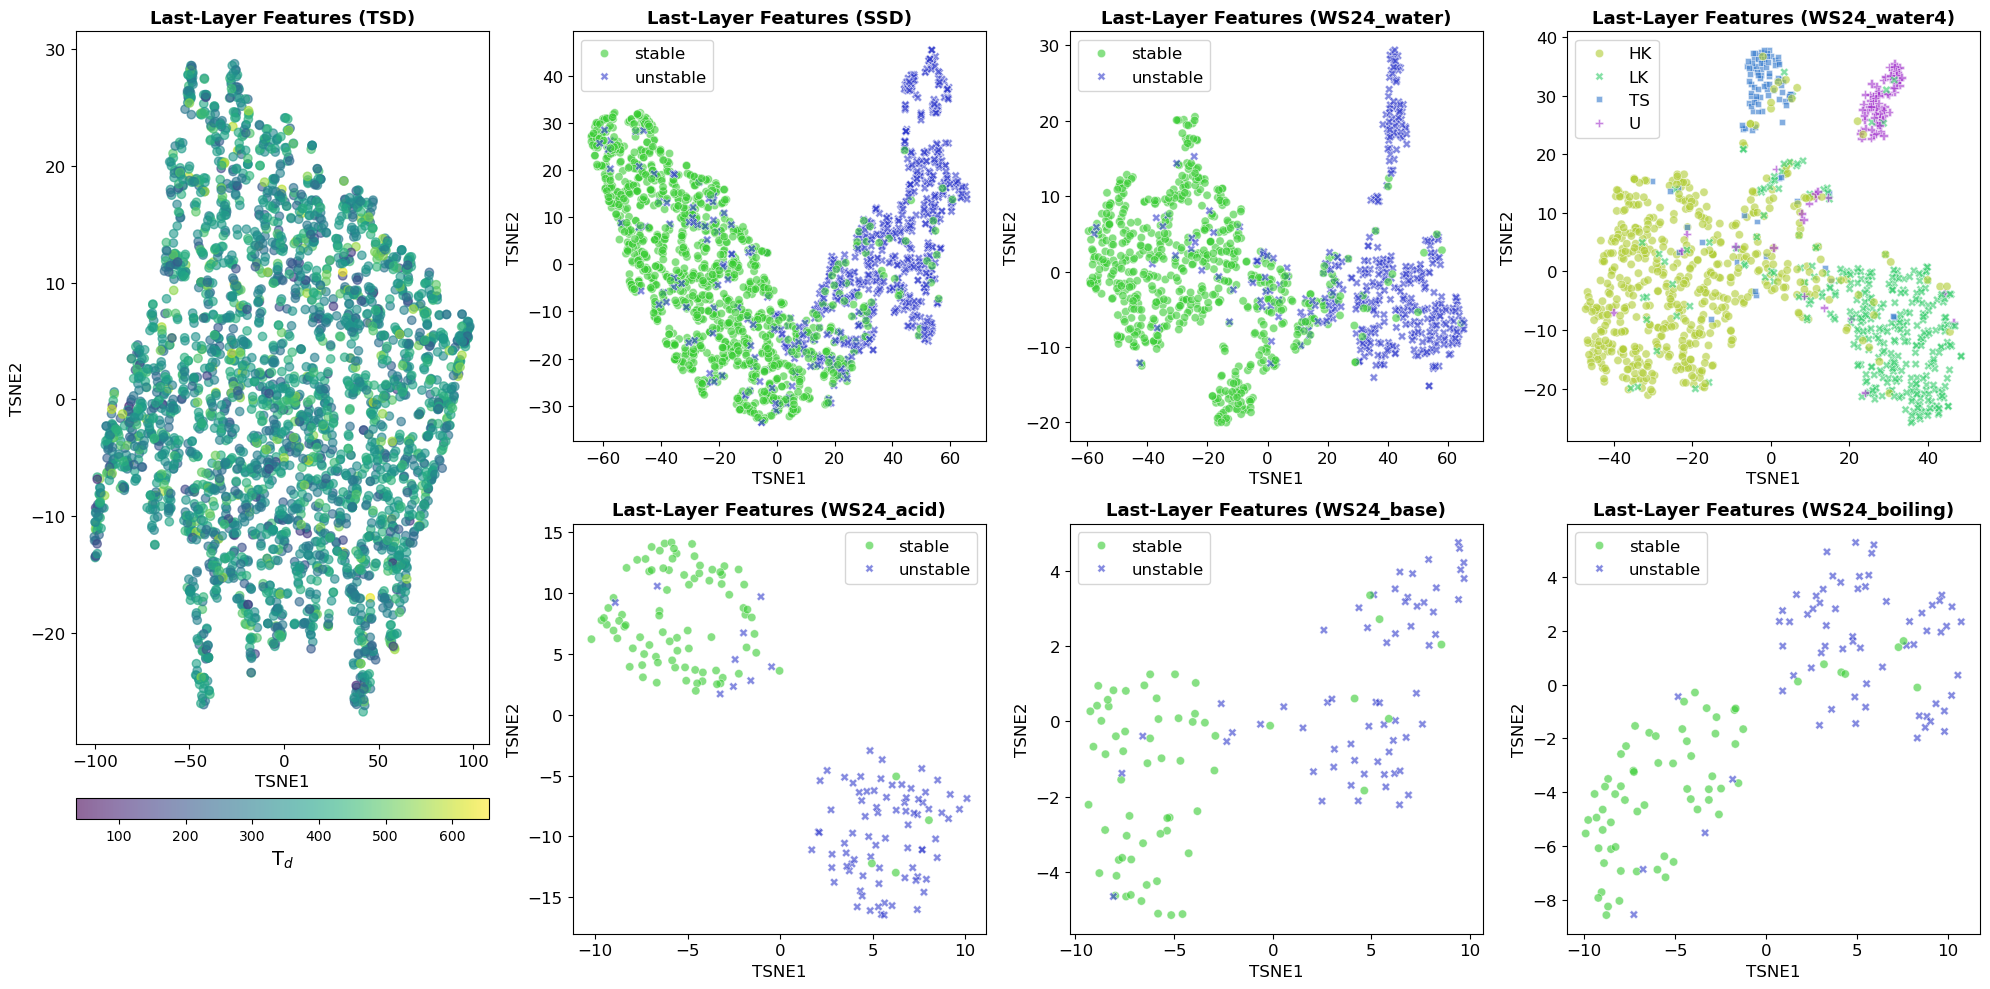

In [4]:
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 4, figure=fig)

ncols = 4
nrows = 2

tsd_ax = gs[0:2, 0]  # lsd_analysis 
plot_tsne_for_task_by_targets("TSD", latent_feas, targets, targets_map, ax=fig.add_subplot(tsd_ax), size=30, alpha=0.6, cb_pad=0.06)
clf_tasks = ["SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]
for i, task in enumerate(clf_tasks):
    fig_file= log_dir/f"{task}_last_layer_tsne_by_targets.png"
    row = i // (ncols-1)
    col = i % (ncols-1)
    ax = gs[i//(ncols-1), i%(ncols-1)+1]
    plot_tsne_for_task_by_targets(task, latent_feas, targets, targets_map, ax=fig.add_subplot(ax), 
                                  size=30, alpha=0.6, x_label=(row == nrows-1), y_label=(col == 0))
    
plt.tight_layout()
plt.savefig(fig_dir/"Last_layer_tsne_by_targets_att_cgcnn.tif", dpi=96)
plt.show()

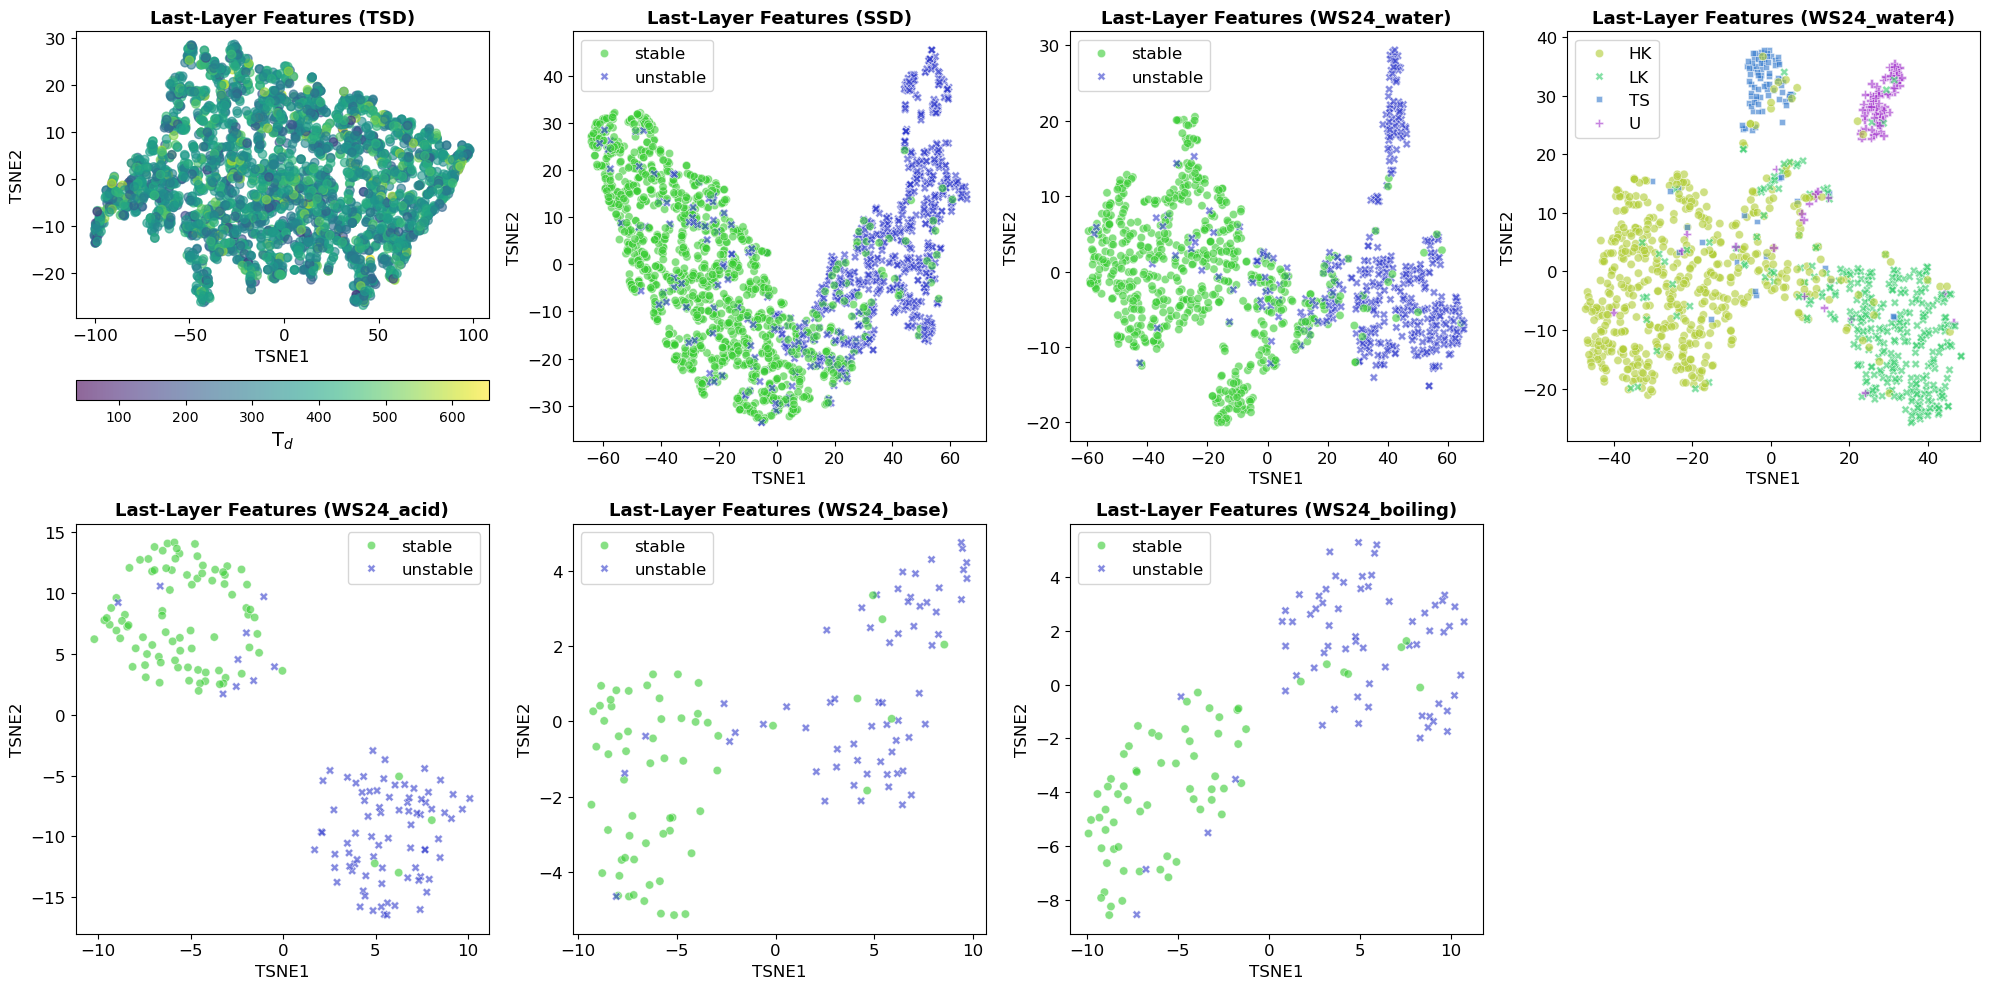

In [5]:
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 4, figure=fig)

ncols = 4
nrows = 2

tsd_ax = gs[0, 0]
plot_tsne_for_task_by_targets("TSD", latent_feas, targets, targets_map, ax=fig.add_subplot(tsd_ax), size=30, alpha=0.6, cb_pad=0.15)
clf_tasks = ["SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]
for i, task in enumerate(clf_tasks):
    fig_file= log_dir/f"{task}_last_layer_tsne_by_targets.png"
    row = (i+1) // (ncols)
    col = (i+1) % (ncols)
    ax = gs[row, col]
    plot_tsne_for_task_by_targets(task, latent_feas, targets, targets_map, ax=fig.add_subplot(ax), 
                                  size=30, alpha=0.6, x_label=(row == nrows-1), y_label=(col == 0))
    
    
plt.tight_layout()
plt.savefig(fig_dir/"Last_layer_tsne_by_targets_att_cgcnn_eq.tif", dpi=96)
plt.show()

In [6]:
def lsd_analysis(task, latent_feas, targets, predictions, k=10, **kwargs):

    alpha = kwargs.get('alpha', 0.8)
    frac_cutoff = kwargs.get('frac_cutoff', 0.8)
    xmax = kwargs.get('xmax', None)
    ax = kwargs.get('ax', None)
    x_label = kwargs.get('x_label', True)
    y_label_left = kwargs.get('y_label_left', True)
    y_label_right = kwargs.get('y_label_right', True)
    tick_font_size = kwargs.get('tick_font_size', 12)
    label_font_size = kwargs.get('label_font_size', 12)
    legend = kwargs.get('legend', False)
    if ax is None:
        fig, ax = plt.subplots()

    norm_avg_knn_dist, avg_distances, avg_traintrain = calculate_lsd(latent_feas[f"{task}_train"], 
                                                                 latent_feas[f"{task}_test"], k=k)
    scaler = MinMaxScaler()
    scaled_avg_knn_dist = scaler.fit_transform(avg_distances.reshape(-1, 1)).reshape(-1)

    cutoffs = []
    performances_in = []
    performances_out = []
    fracs = []
    r2_scores_in = []
    for i in range(1, 96, 1):
        sub_targets = targets[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        sub_preds = predictions[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        sub_targets_out = targets[f"{task}_test"][np.where(scaled_avg_knn_dist > 0.01*i)[0]]
        sub_preds_out = predictions[f"{task}_test"][np.where(scaled_avg_knn_dist > 0.01*i)[0]]
        cutoffs.append(0.01*i)
        performances_in.append(metrics.mean_absolute_error(sub_targets, sub_preds))
        performances_out.append(metrics.mean_absolute_error(sub_targets_out, sub_preds_out))
        r2_scores_in.append(metrics.r2_score(sub_targets, sub_preds))
        frac = len(sub_targets)/len(targets[f"{task}_test"])
        fracs.append(frac)
        if frac > frac_cutoff:
            print (f"LSD cutoff={0.01*i}, MAE={metrics.mean_absolute_error(sub_targets, sub_preds)}, R2={metrics.r2_score(sub_targets, sub_preds)}")
            break

    metric_full = metrics.mean_absolute_error(targets[f"{task}_test"], predictions[f"{task}_test"])
    sns.scatterplot(x=cutoffs, y=performances_in, ax=ax, marker='D', label='MAE/ACC of Data inside Cutoff', alpha=alpha)
    sns.scatterplot(x=cutoffs, y=performances_out, ax=ax, marker='^', label='MAE/ACC of Data outside Cutoff', alpha=alpha)
    if x_label:
        ax.set_xlabel('Uncertainty Cutoff')
    if y_label_left:
        ax.set_ylabel('Mean Absolute Error (℃)')
    ax.set_ylim(10, 60)
    

    ax2 = ax.twinx()
    sns.scatterplot(x=cutoffs, y=fracs, ax=ax2, color='g', marker='o', label='Retained Data Fraction', alpha=alpha)
    # ax2.vlines(x=cutoff, ymin=0, ymax=1.2, colors='gray', linestyles='dashed', label=f'LSD Cutoff={cutoff:.2f}', alpha=alpha)
    if y_label_right:
        ax2.set_ylabel('Fraction')
    ax2.set_ylim(-0.01, 1.05)

    if xmax is None:
        xmax = cutoffs[-1]
    ax.set_xlim(0, xmax)
    ax.hlines(y=metric_full, xmin=0, xmax=xmax, colors='blue', linestyles='dashed', label=f'MAE/ACC of full test set', alpha=alpha)
    ax2.text(xmax*0.1, 0.2, "\n".join([  
                                          
                                          f'MAE={performances_in[-1]:.1f}℃',
                                          f'R2={r2_scores_in[-1]:.2f}',
                                          'when:',
                                          'LSD$_{cutoff}$=' + f'{cutoffs[-1]:.2f}',
                                          ]), 
                                         fontsize=tick_font_size, ha='left', va='center', color='r')
    ax.text(xmax*0.05, metric_full*0.95, f"MAE={metric_full:.1f}", fontsize=tick_font_size, ha='left', va='center', color='b')
    if legend:
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # ax2.legend(loc='lower right', bbox_to_anchor=(1, 1))
        ax.legend(handles1 + handles2, labels1 + labels2, loc='upper right')
        ax2.legend().set_visible(False)
    else:
        ax.legend().set_visible(False)
        ax2.legend().set_visible(False)
    # fig.suptitle(f'MAE & Fraction vs Cutoff ({task})')
    ax.set_title(f'MAE & Fraction vs LSD Cutoff ({task})', weight='bold', fontsize=label_font_size)
    ax.tick_params(axis='both', labelsize=tick_font_size)
    ax.xaxis.label.set_size(label_font_size)
    ax.yaxis.label.set_size(label_font_size)
    ax2.tick_params(axis='both', labelsize=tick_font_size)
    ax2.yaxis.label.set_size(label_font_size)
    return ax

def lsd_analysis_clf(task, latent_feas, targets, predictions, probs, k=10, **kwargs):

    alpha = kwargs.get('alpha', 0.8)
    frac_cutoff = kwargs.get('frac_cutoff', 0.8)
    xmax = kwargs.get('xmax', None)
    ax = kwargs.get('ax', None)
    x_label = kwargs.get('x_label', True)
    y_label_left = kwargs.get('y_label_left', True)
    y_label_right = kwargs.get('y_label_right', True)
    tick_font_size = kwargs.get('tick_font_size', 12)
    label_font_size = kwargs.get('label_font_size', 12)
    legend = kwargs.get('legend', False)
    if ax is None:
        fig, ax = plt.subplots()

    norm_avg_knn_dist, avg_distances, avg_traintrain = calculate_lsd(latent_feas[f"{task}_train"], 
                                                                 latent_feas[f"{task}_test"], k=k)
    scaler = MinMaxScaler()
    scaled_avg_knn_dist = scaler.fit_transform(avg_distances.reshape(-1, 1)).reshape(-1)

    cutoffs = []
    performances_in = []
    performances_out = []
    aucs_in = []
    fracs = []

    for i in range(1, 101, 1):
        sub_targets = targets[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        sub_preds = predictions[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        sub_targets_out = targets[f"{task}_test"][np.where(scaled_avg_knn_dist > 0.01*i)[0]]
        sub_preds_out = predictions[f"{task}_test"][np.where(scaled_avg_knn_dist > 0.01*i)[0]]
        sub_probs_in = probs[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        cutoffs.append(0.01*i)
        performances_in.append(metrics.accuracy_score(sub_targets, sub_preds))
        performances_out.append(metrics.accuracy_score(sub_targets_out, sub_preds_out))
        try:
            aucs_in.append(metrics.roc_auc_score(sub_targets, sub_probs_in, multi_class="ovo"))
        except ValueError:
            aucs_in.append(0.5)
        
        frac = len(sub_targets)/len(targets[f"{task}_test"])
        fracs.append(frac)
        if frac > frac_cutoff:
            print (f"LSE cutoff={0.01*i}, Accuracy={metrics.accuracy_score(sub_targets, sub_preds)}")
            break

    metric_full = metrics.accuracy_score(targets[f"{task}_test"], predictions[f"{task}_test"])
    sns.scatterplot(x=cutoffs, y=performances_in, ax=ax, marker='D', label='ACC of Data inside Cutoff', alpha=alpha)
    sns.scatterplot(x=cutoffs, y=performances_out, ax=ax, marker='^', label='ACC of Data outside Cutoff', alpha=alpha)
    
    if x_label:
        ax.set_xlabel('Uncertainty Cutoff')
    if y_label_left:
        ax.set_ylabel('Accuracy')
    ax.set_ylim(-0.01, 1.05)

    ax2 = ax.twinx()
    sns.scatterplot(x=cutoffs, y=fracs, ax=ax2, color='g', marker='o', label='Retained Data Fraction', alpha=alpha)
    # ax2.vlines(x=cutoff, ymin=0, ymax=1.2, colors='gray', linestyles='dashed', label=f'LSD Cutoff={cutoff:.2f}', alpha=alpha)
    if y_label_right:
        ax2.set_ylabel('Fraction')
    ax2.set_ylim(-0.01, 1.05)

    if xmax is None:
        xmax = cutoffs[-1]
    ax.set_xlim(0, xmax)
    ax.hlines(y=metric_full, xmin=0, xmax=xmax, colors='blue', linestyles='dashed', 
              label=f'MAE/ACC of full test set', alpha=alpha)
    ax2.text(xmax*0.65, 0.3, "\n".join([  
                                          f'ACC={performances_in[-1]:.2f}',
                                          f'AUROC={aucs_in[-1]:.2f}',
                                          'when:',
                                          'LSE$_{cutoff}$=' + f'{cutoffs[-1]:.2f}',
                                          ]), 
                                         fontsize=tick_font_size, ha='left', va='center', color='r')
    ax2.text(xmax*0.78, metric_full*0.96, f"ACC={metric_full:.2f}", fontsize=tick_font_size, ha='left', va='center', color='b')

    # fig.suptitle(f'Accuracy & Fraction vs LSE Cutoff ({task})')
    if legend:
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # ax2.legend(loc='lower right', bbox_to_anchor=(1, 1))
        ax.legend(handles1 + handles2, labels1 + labels2, loc='lower right')
        ax2.legend().set_visible(False)
    else:
        ax.legend().set_visible(False)
        ax2.legend().set_visible(False)
    ax.set_title(f'Accuracy & Fraction vs LSE Cutoff ({task})', weight='bold', fontsize=label_font_size)
    ax.tick_params(axis='both', labelsize=tick_font_size)
    ax.xaxis.label.set_size(label_font_size)
    ax.yaxis.label.set_size(label_font_size)
    ax2.tick_params(axis='both', labelsize=tick_font_size)
    ax2.yaxis.label.set_size(label_font_size)
    return ax

def lse_analysis(task, latent_feas, targets, predictions, probs, k=10, **kwargs):
    avg_distances = calculate_lse(latent_feas[f"{task}_train"], 
                                targets[f"{task}_train"], 
                                latent_feas[f"{task}_test"], k=k)
    
    alpha = kwargs.get('alpha', 0.8)
    xmax = kwargs.get('xmax', None)
    ax = kwargs.get('ax', None)
    frac_cutoff = kwargs.get('frac_cutoff', 0.8)
    x_label = kwargs.get('x_label', True)
    y_label_left = kwargs.get('y_label_left', True)
    y_label_right = kwargs.get('y_label_right', True)
    legend = kwargs.get('legend', False)
    tick_font_size = kwargs.get('tick_font_size', 12)
    label_font_size = kwargs.get('label_font_size', 12)

    if ax is None:
        fig, ax = plt.subplots()

    # num_classes = len(np.unique(targets[f"{task}_train"]))
    scaler = MinMaxScaler()
    scaled_avg_knn_dist = scaler.fit_transform(avg_distances.reshape(-1, 1)).reshape(-1)

    cutoffs = []
    performances_in = []
    performances_out = []
    aucs_in = []
    fracs = []

    for i in range(1, 101, 1):
        sub_targets = targets[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        sub_preds = predictions[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        sub_targets_out = targets[f"{task}_test"][np.where(scaled_avg_knn_dist > 0.01*i)[0]]
        sub_preds_out = predictions[f"{task}_test"][np.where(scaled_avg_knn_dist > 0.01*i)[0]]
        sub_probs_in = probs[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        cutoffs.append(0.01*i)
        performances_in.append(metrics.accuracy_score(sub_targets, sub_preds))
        performances_out.append(metrics.accuracy_score(sub_targets_out, sub_preds_out))
        try:
            aucs_in.append(metrics.roc_auc_score(sub_targets, sub_probs_in, multi_class="ovo"))
        except ValueError:
            aucs_in.append(0.5)
        
        frac = len(sub_targets)/len(targets[f"{task}_test"])
        fracs.append(frac)
        if frac > frac_cutoff:
            print (f"LSE cutoff={0.01*i}, Accuracy={metrics.accuracy_score(sub_targets, sub_preds)}")
            break

    metric_full = metrics.accuracy_score(targets[f"{task}_test"], predictions[f"{task}_test"])
    sns.scatterplot(x=cutoffs, y=performances_in, ax=ax, marker='D', label='ACC of Data inside Cutoff', alpha=alpha)
    sns.scatterplot(x=cutoffs, y=performances_out, ax=ax, marker='^', label='ACC of Data outside Cutoff', alpha=alpha)
    
    if x_label:
        ax.set_xlabel('Uncertainty Cutoff')
    if y_label_left:
        ax.set_ylabel('Accuracy')
    ax.set_ylim(-0.01, 1.05)

    ax2 = ax.twinx()
    sns.scatterplot(x=cutoffs, y=fracs, ax=ax2, color='g', marker='o', label='Retained Data Fraction', alpha=alpha)
    # ax2.vlines(x=cutoff, ymin=0, ymax=1.2, colors='gray', linestyles='dashed', label=f'LSD Cutoff={cutoff:.2f}', alpha=alpha)
    if y_label_right:
        ax2.set_ylabel('Fraction')
    ax2.set_ylim(-0.01, 1.05)

    if xmax is None:
        xmax = cutoffs[-1]
    ax.set_xlim(0, xmax)
    ax.hlines(y=metric_full, xmin=0, xmax=xmax, colors='blue', linestyles='dashed', 
              label=f'MAE/ACC of full test set', alpha=alpha)
    ax2.text(xmax*0.65, 0.3, "\n".join([  
                                          f'ACC={performances_in[-1]:.2f}',
                                          f'AUROC={aucs_in[-1]:.2f}',
                                          'when:',
                                          'LSE$_{cutoff}$=' + f'{cutoffs[-1]:.2f}',
                                          ]), 
                                         fontsize=tick_font_size, ha='left', va='center', color='r')
    ax2.text(xmax*0.78, metric_full*0.96, f"ACC={metric_full:.2f}", fontsize=tick_font_size, ha='left', va='center', color='b')

    # fig.suptitle(f'Accuracy & Fraction vs LSE Cutoff ({task})')
    if legend:
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # ax2.legend(loc='lower right', bbox_to_anchor=(1, 1))
        ax.legend(handles1 + handles2, labels1 + labels2, loc='lower right')
        ax2.legend().set_visible(False)
    else:
        ax.legend().set_visible(False)
        ax2.legend().set_visible(False)
    ax.set_title(f'Accuracy & Fraction vs LSE Cutoff ({task})', weight='bold', fontsize=label_font_size)
    ax.tick_params(axis='both', labelsize=tick_font_size)
    ax.xaxis.label.set_size(label_font_size)
    ax.yaxis.label.set_size(label_font_size)
    ax2.tick_params(axis='both', labelsize=tick_font_size)
    ax2.yaxis.label.set_size(label_font_size)
    return ax

def lsv_analysis(task, latent_feas, targets, predictions, k=10, **kwargs):
    avg_distances = calculate_lsv(latent_feas[f"{task}_train"], 
                                targets[f"{task}_train"], 
                                latent_feas[f"{task}_test"], k=k)
    
    alpha = kwargs.get('alpha', 0.8)
    xmax = kwargs.get('xmax', None)
    ax = kwargs.get('ax', None)
    frac_cutoff = kwargs.get('frac_cutoff', 0.8)
    x_label = kwargs.get('x_label', True)
    y_label_left = kwargs.get('y_label_left', True)
    y_label_right = kwargs.get('y_label_right', True)
    legend = kwargs.get('legend', False)
    tick_font_size = kwargs.get('tick_font_size', 12)
    label_font_size = kwargs.get('label_font_size', 12)

    if ax is None:
        fig, ax = plt.subplots()

    # num_classes = len(np.unique(targets[f"{task}_train"]))
    scaler = MinMaxScaler()
    scaled_avg_knn_dist = scaler.fit_transform(avg_distances.reshape(-1, 1)).reshape(-1)

    cutoffs = []
    performances_in = []
    performances_out = []
    fracs = []
    r2_scores_in = []
    for i in range(1, 96, 1):
        sub_targets = targets[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        sub_preds = predictions[f"{task}_test"][np.where(scaled_avg_knn_dist <= 0.01*i)[0]]
        sub_targets_out = targets[f"{task}_test"][np.where(scaled_avg_knn_dist > 0.01*i)[0]]
        sub_preds_out = predictions[f"{task}_test"][np.where(scaled_avg_knn_dist > 0.01*i)[0]]
        cutoffs.append(0.01*i)
        performances_in.append(metrics.mean_absolute_error(sub_targets, sub_preds))
        performances_out.append(metrics.mean_absolute_error(sub_targets_out, sub_preds_out))
        r2_scores_in.append(metrics.r2_score(sub_targets, sub_preds))
        frac = len(sub_targets)/len(targets[f"{task}_test"])
        fracs.append(frac)
        if frac > frac_cutoff:
            print (f"LSV cutoff={0.01*i}, MAE={metrics.mean_absolute_error(sub_targets, sub_preds)}, R2={metrics.r2_score(sub_targets, sub_preds)}")
            break

    metric_full = metrics.mean_absolute_error(targets[f"{task}_test"], predictions[f"{task}_test"])
    sns.scatterplot(x=cutoffs, y=performances_in, ax=ax, marker='D', label='MAE/ACC of Data inside Cutoff', alpha=alpha)
    sns.scatterplot(x=cutoffs, y=performances_out, ax=ax, marker='^', label='MAE/ACC of Data outside Cutoff', alpha=alpha)
    if x_label:
        ax.set_xlabel('Uncertainty Cutoff')
    if y_label_left:
        ax.set_ylabel('Mean Absolute Error (℃)')
    ax.set_ylim(10, 60)
    

    ax2 = ax.twinx()
    sns.scatterplot(x=cutoffs, y=fracs, ax=ax2, color='g', marker='o', label='Retained Data Fraction', alpha=alpha)
    # ax2.vlines(x=cutoff, ymin=0, ymax=1.2, colors='gray', linestyles='dashed', label=f'LSD Cutoff={cutoff:.2f}', alpha=alpha)
    if y_label_right:
        ax2.set_ylabel('Fraction')
    ax2.set_ylim(-0.01, 1.05)

    if xmax is None:
        xmax = cutoffs[-1]
    ax.set_xlim(0, xmax)
    ax.hlines(y=metric_full, xmin=0, xmax=xmax, colors='blue', linestyles='dashed', label=f'MAE/ACC of full test set', alpha=alpha)
    ax2.text(xmax*0.65, 0.3, "\n".join([  
                                          
                                          f'MAE={performances_in[-1]:.1f}',
                                          f'R2={r2_scores_in[-1]:.2f}',
                                          'when:',
                                          'LSV$_{cutoff}$=' + f'{cutoffs[-1]:.2f}',
                                          ]), 
                                         fontsize=tick_font_size, ha='left', va='center', color='r')
    ax.text(xmax*0.05, metric_full*0.95, f"MAE={metric_full:.1f}", fontsize=tick_font_size, ha='left', va='center', color='b')
    if legend:
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # ax2.legend(loc='lower right', bbox_to_anchor=(1, 1))
        ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')
        ax2.legend().set_visible(False)
    else:
        ax.legend().set_visible(False)
        ax2.legend().set_visible(False)
    # fig.suptitle(f'MAE & Fraction vs Cutoff ({task})')
    ax.set_title(f'MAE & Fraction vs LSV Cutoff ({task})', weight='bold', fontsize=label_font_size)
    ax.tick_params(axis='both', labelsize=tick_font_size)
    ax.xaxis.label.set_size(label_font_size)
    ax.yaxis.label.set_size(label_font_size)
    ax2.tick_params(axis='both', labelsize=tick_font_size)
    ax2.yaxis.label.set_size(label_font_size)
    return ax

LSV cutoff=0.34, MAE=43.629903173652686, R2=0.4588259629761885
Average distance to 5 nearest neighbors in training data: 0.36066706562992007
LSE cutoff=0.55, Accuracy=0.7628571428571429
Average distance to 5 nearest neighbors in training data: 0.4761503534393861
LSE cutoff=0.77, Accuracy=0.7921348314606742
Average distance to 5 nearest neighbors in training data: 0.7170741908624748
LSE cutoff=0.92, Accuracy=0.7175141242937854
Average distance to 5 nearest neighbors in training data: 1.0053848328591035
LSE cutoff=0.74, Accuracy=0.8666666666666667
Average distance to 5 nearest neighbors in training data: 1.1062062145574094
LSE cutoff=0.54, Accuracy=0.8
Average distance to 5 nearest neighbors in training data: 1.0884847029064282
LSE cutoff=0.5, Accuracy=0.8095238095238095


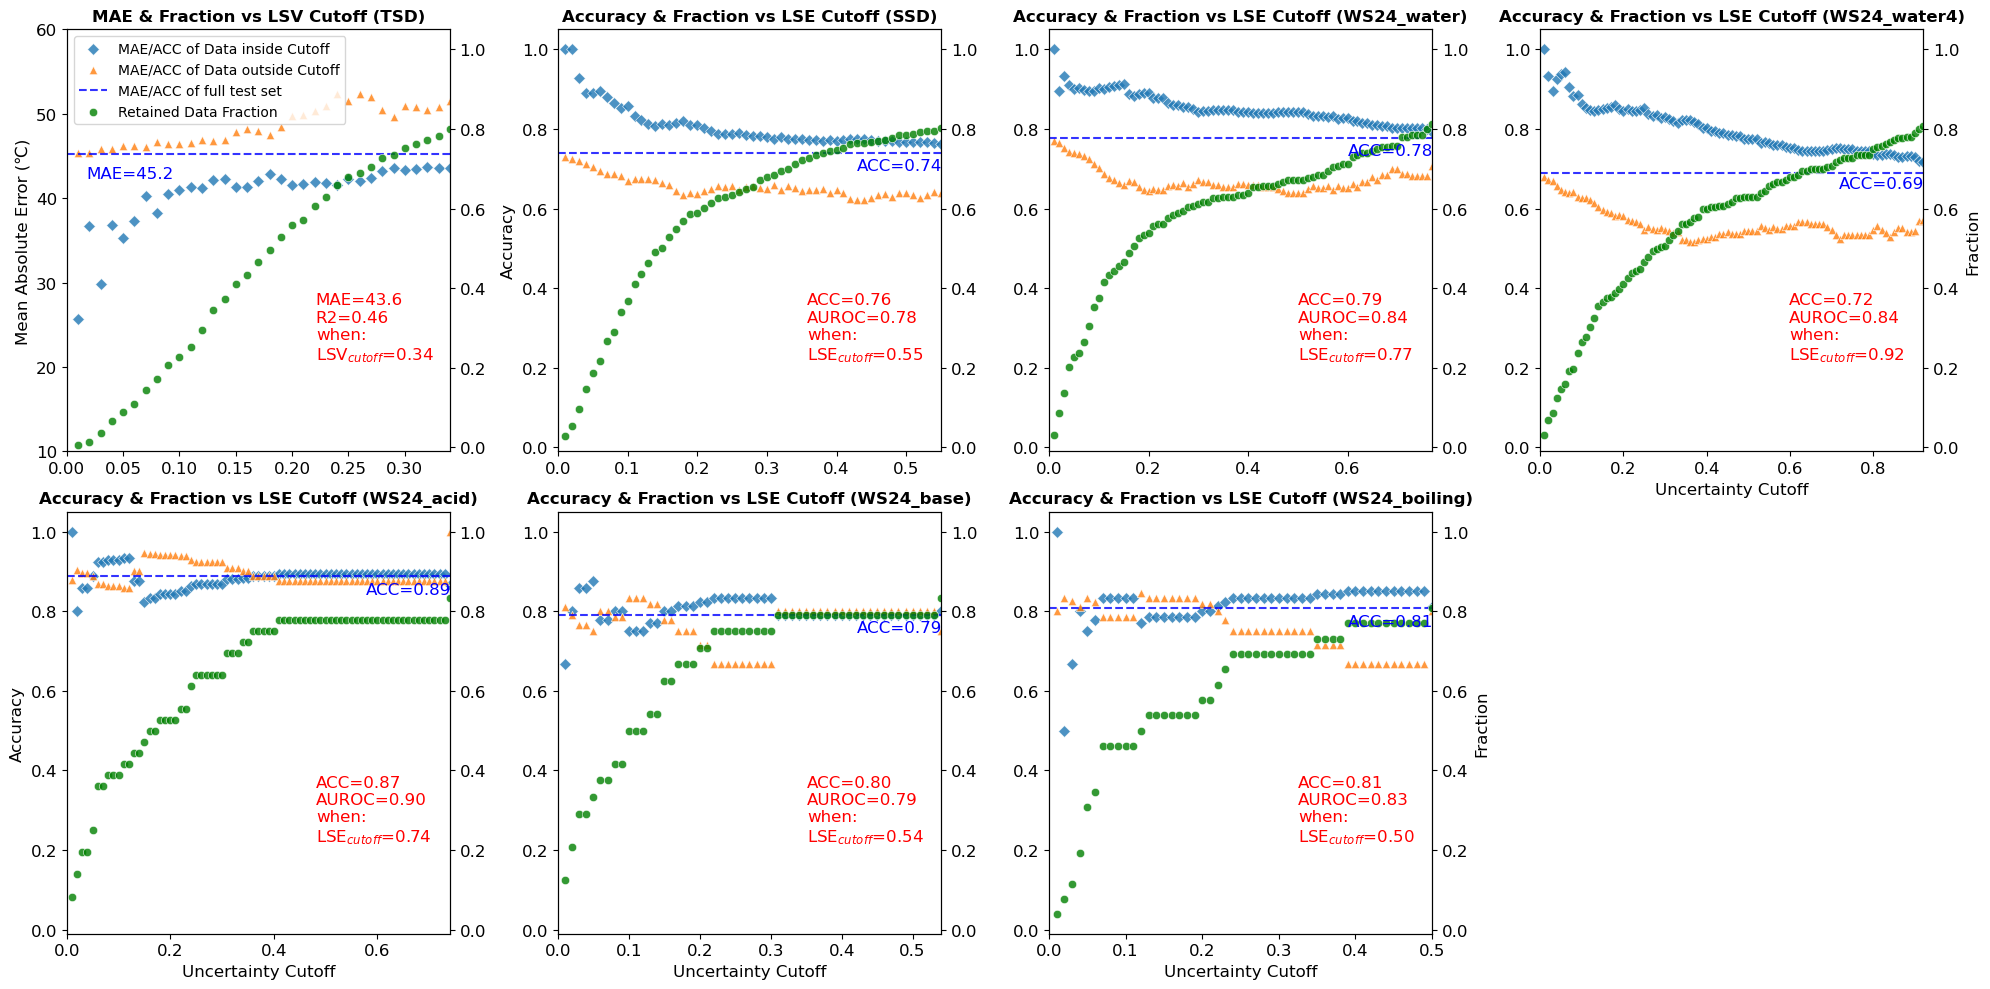

In [7]:
# fig, ax = plt.subplots(figsize=(8, 6))
# task = "TSD"
# ax = lsd_analysis(task, latent_feas, targets, predictions, k=5, ax=ax,  alpha=0.8, frac_cutoff=0.8)


# Create a large figure with 7 subplots, using a 4x2 layout
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 4, figure=fig)

ncols = 4
nrows = 2

lsd_ax = gs[0, 0]  # lsd_analysis function occupies the first and second subplot positions
lse_axes = [gs[i//(ncols-1), i%(ncols-1)+1] for i in range(6)]  # lse_analysis function occupies the subsequent 6 subplot positions

# Call lsd_analysis function, occupying the first and second subplot positions
lsv_analysis('TSD', latent_feas, targets, predictions, k=5, ax=fig.add_subplot(lsd_ax), frac_cutoff=0.8, x_label=False, y_label_left=True, y_label_right=False, legend=True)

# Call lse_analysis function, occupying the subsequent 6 subplot positions
clf_tasks = ["SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]
for i, task in enumerate(clf_tasks):
    n = i+1
    row = n // (ncols)
    col = n % (ncols)
    lse_ax = gs[row, col]
    lse_analysis(task, latent_feas, targets, predictions, probs, k=5, ax=fig.add_subplot(lse_ax), frac_cutoff=0.8, 
                 x_label=(row == 1)|(col == 3 and row == 0), 
                 y_label_left=(col == 0 and row == 1)|(col == 1 and row == 0), 
                 y_label_right=(col == 2 and row == 1)|(col == 3 and row == 0), 
                 legend=False)

# Adjust the spacing and layout between subplots
plt.tight_layout()
plt.savefig(fig_dir/"LSDandLSE_calc.tif", dpi=96)
plt.show()